In [1]:
from feature_engine import FeatureEngine
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_auc_score
import shap

"""
Try K-means on all features
"""

/Users/nikhilnarayanan/Desktop/FYP/REPLACE-BG/my-python3-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'\nTry K-means on all features\n'

In [2]:
dataset = FeatureEngine()

In [3]:
rus = RandomUnderSampler(sampling_strategy=0.333,)
x_train, y_train = rus.fit_resample(np.array(dataset.training_set), np.array(dataset.training_labels.astype(int)))

In [4]:
dataset.training_set

,mean_diff,median_diff,mffcs,spectral_decrease_11h,tbr_last_1_hour,tbr_last_3_hours,tbr_last_6_hours,tbr_last_12_hours,centroid_last_1_hour,centroid_last_3_hours,...,Weight_bin_2.0,Weight_bin_1.0,Weight_bin_3.0,Weight_bin_5.0,Height_bin_0.0,Height_bin_4.0,Height_bin_1.0,Height_bin_3.0,Height_bin_2.0,Height_bin_5.0
0,-2.909091,-3.0,180.132500,-0.747809,0.0,0.0,0.000000,0.000000,2.983062,7.019365,...,0,0,0,1,0,0,0,0,0,1
1,-2.090909,-2.0,167.117823,-0.438858,0.0,0.0,0.000000,0.000000,3.256153,7.291353,...,0,0,1,0,0,0,0,0,0,1
2,1.818182,4.5,181.353698,-1.351592,0.0,0.0,0.000000,0.034722,3.130713,6.320796,...,0,0,1,0,0,0,0,1,0,0
3,-2.181818,-2.0,181.338594,-0.096197,0.0,0.0,0.000000,0.000000,3.171529,3.889146,...,0,1,0,0,0,0,1,0,0,0
4,-2.181818,-2.0,184.387061,-1.561170,0.0,0.0,0.000000,0.000000,3.294884,7.391193,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29534,-3.090909,-4.0,179.268870,-1.173894,0.0,0.0,0.000000,0.000000,3.195791,6.706515,...,0,0,1,0,0,0,0,1,0,0
29535,-1.454545,-1.0,178.480605,-0.822637,0.0,0.0,0.000000,0.000000,3.225740,6.825384,...,1,0,0,0,0,1,0,0,0,0
29536,2.227273,2.0,160.074754,-1.499225,0.0,0.0,0.000000,0.020833,3.343876,7.049639,...,1,0,0,0,0,0,0,0,1,0
29537,1.181818,1.0,170.079228,0.067143,0.0,0.0,0.069444,0.069444,3.196084,6.385267,...,1,0,0,0,1,0,0,0,0,0


In [8]:
bst = XGBClassifier(objective="binary:logistic", eval_metric="auc")
bst.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [9]:
preds = bst.predict(dataset.training_set)
roc_auc_score(dataset.training_labels, preds)

0.5526905463327277

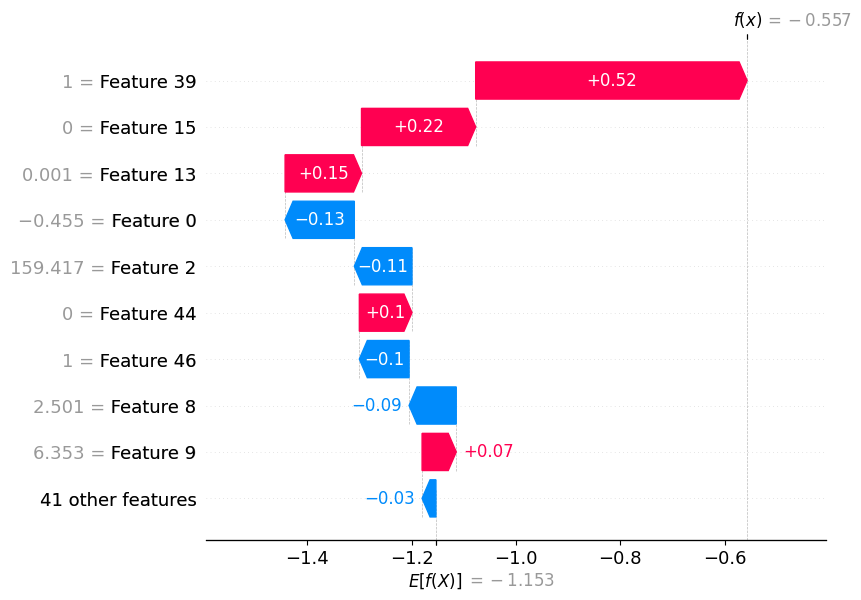

In [7]:
explainer = shap.Explainer(bst)
shap_values = explainer(x_train)
shap.plots.waterfall(shap_values[0])